In [23]:
import numpy as np
import matplotlib.pyplot as plt

import mfem.ser as mfem
from bfp import *
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData

import os
import h5py

#import math
#import mpi4py.MPI as MPI
#print(MPI.Get_version())

In [24]:
class EnergyDependentCoefficient(mfem.PyCoefficient):
    """Energy-dependent coefficient using either a constant or a one-dimensional array.

    This coefficient maps a normalized integration coordinate (j[1] in [0, 1])
    to a value by linearly interpolating data over an interval defined by E_start and E_end.
    If a constant is provided (e.g., 1), the coefficient returns this constant at all points.

    Examples:
        EnergyDependentCoefficient(1)
            # Always returns 1.

        EnergyDependentCoefficient(data_array, E_start=0.0, E_end=10.0)
            # Returns the interpolated value from data_array.
    """

    def __init__(self, data, E_start=None, E_end=None):
        super(EnergyDependentCoefficient, self).__init__()
        if isinstance(data, (int, float)):
            self.constant = True
            self.constant_value = float(data)
        else:
            self.constant = False
            self.data = data
            self.E_start = E_start
            self.E_end = E_end

    def EvalValue(self, ip):
        """Evaluates the coefficient at a given normalized energy coordinate.

        Args:
            x (list or array-like): Integration point coordinates, where x[1] is the normalized 
                                    energy in the range [0, 1].

        Returns:
            float: The interpolated coefficient value corresponding to the computed energy.
        """
        if self.constant:
            return self.constant_value

        y = ip.y
        E = self.E_start + y * (self.E_end - self.E_start)
        n_groups = len(self.data)
        group = min(n_groups - 1, int((E - self.E_start) / (self.E_end - self.E_start) * n_groups))
        return float(self.data[group])
    
class XDependentCoefficient(mfem.PyCoefficient):
    """X-dependent coefficient using either a constant or a one-dimensional array.

    This coefficient maps a normalized x coordinate (x[0] in [0, 1])
    to a value by linearly interpolating data over an interval defined by x_start and x_end.
    If a constant is provided (e.g., 1), it is converted to an array (with two points)
    and then processed identically to an array input.

    Examples:
        XDependentCoefficient(1)
            # Always returns 1.

        XDependentCoefficient(data_array, x_start=0.0, x_end=1.0)
            # Returns the interpolated value from data_array.
    """

    def __init__(self, data, x_start=None, x_end=None):
        super(XDependentCoefficient, self).__init__()
        if isinstance(data, (int, float)):
            self.constant = True
            self.constant_value = float(data)
        else:
            self.constant = False
            self.data = data
            self.x_start = x_start
            self.x_end = x_end

    def EvalValue(self, x):
        """Evaluates the coefficient at a given normalized x coordinate.

        This method converts the normalized x coordinate (x[0]) to a physical x
        value, determines the corresponding index (group) in the data array via linear 
        interpolation, and returns the associated coefficient value.

        Args:
            x (list or array-like): A coordinate array where x[0] is the normalized x 
                (in the range [0, 1]).

        Returns:
            float: The interpolated coefficient value corresponding to the computed x.
        """
        if self.constant:
            return self.constant_value

        y = x[0]
        x_val = self.x_start + y * (self.x_end - self.x_start)
        n_groups = len(self.data)
        group = min(n_groups - 1, int((x_val - self.x_start) / (self.x_end - self.x_start) * n_groups))
        return float(self.data[group])
    
class VelocityCoefficient2(mfem.VectorPyCoefficientBase):
    """Velocity vector coefficient for the transport equation.

    Defines a velocity vector:
        v(x) = [μ, S(E)]

    Attributes:
        mu (float): Scalar value, e.g., discrete ordinate.
        S_coef (Coefficient): Coefficient object used to evaluate S(E) at given points.
    """
    def __init__(self, mu, S_coef):
        mfem.VectorPyCoefficientBase.__init__(self, 2, 0)
        self.mu = mu
        self.S_coef = S_coef

    def _EvalPy(self, V, ip):
        """Evaluates the velocity vector at a given integration point.

        Args:
            V (array_like): Output vector of size 2 to store the velocity.
            ip (IntegrationPoint): Integration point where the evaluation occurs.
        """
        V[0] = self.mu
        V[1] = self.S_coef.EvalValue(ip)
        return V


File '/Users/melekderman/github/BFP/examples1/mesh/usr/20x50_2D.mesh' already exists.
Number of unknowns: 4000
  Solving for mu = -0.9602898564975362
    GMRES (mu = -0.9602898564975362 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = -0.7966664774136267
    GMRES (mu = -0.7966664774136267 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = -0.525532409916329
    GMRES (mu = -0.525532409916329 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = -0.1834346424956498
    GMRES (mu = -0.1834346424956498 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = 0.1834346424956498
    GMRES (mu = 0.1834346424956498 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = 0.525532409916329
    GMRES (mu = 0.525532409916329 ): iterations = 1 final norm = 9.899146047999691e-11
  Solving for mu = 0.7966664774136267
    GMRES (mu = 0.7966664774136267 ): iterations = 1 final norm = 9.899146047999691e-11
  S

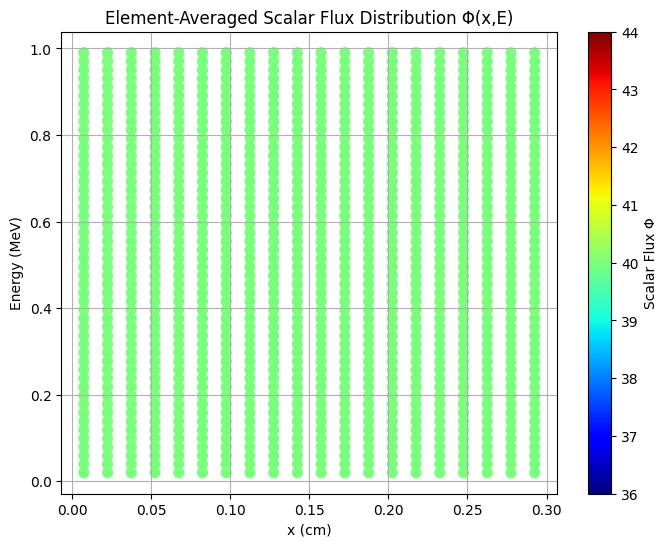

In [25]:
# Set parameters
nx = 20         
nE = 50         
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 8       
order = 1

# Create mesh and finite element space
mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()

fec = mfem.L2_FECollection(order, dim)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetTrueVSize()
print("Number of unknowns:", Size)

# Define necessary coefficients 
mu_vals, w_vals = gauss_legendre_dirs(N_ang)
xs_t_coeff = EnergyDependentCoefficient(5)
xs_s_coeff = EnergyDependentCoefficient(0)
S_coeff    = EnergyDependentCoefficient(0)
dS_dE_coeff = EnergyDependentCoefficient(0)
q_coeff = EnergyDependentCoefficient(100)
inflow_val = mfem.ConstantCoefficient(0)

# Set the initial scalar flux
phi = mfem.GridFunction(fes)
phi.Assign(1.0)

psi_mu_list = []

# Angular sweep
for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)

    # Create the velocity coefficient based on mu and S(E)
    v_coef = VelocityCoefficient(mu, S_coeff)

    # Set up the DG bilinear form A(.,.)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5))) 
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coef, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    # Set up the linear form b for the RHS
    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    #scattering_source = mfem.ProductCoefficient(xs_s_coeff, mfem.GridFunctionCoefficient(phi))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_val, v_coef, -1.0, -0.5))
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)  # initial guess
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)
    print("    GMRES (mu =", mu, "): iterations =", solver.GetNumIterations(),
          "final norm =", solver.GetFinalNorm())
    
    # Append the angular solution for mu
    psi_mu_list.append((mu, w, psi))
    
    # Save each angular solution and corresponding mesh.
    psi.Save("psi_mu_list{:.3f}.gf".format(mu))
    #mesh.Save("mesh_mu_{:.3f}.mesh".format(mu))
    glvis((mesh, psi))

# Combine angular solutions to compute the scalar flux:
phi_new = mfem.GridFunction(fes)
phi_new.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi_new.Add(w, psi)
    
# Save the final scalar flux φ to file.
phi_new.Save("phi_new.gf")
print("\nScalar flux saved to file: phi.gf")


# Compute cell centers and element-wise average flux for plotting
num_cells = mesh.GetNE()
cell_centers = np.zeros((num_cells, 2))
phi_cell_avg = np.zeros(num_cells)
center = mfem.Vector(dim)

for i in range(num_cells):
    mesh.GetElementCenter(i, center)
    cell_centers[i, :] = [center[0], center[1]]
    dof_indices = fes.GetElementDofs(i)
    phi_vals = [phi_new[dof] for dof in dof_indices]
    phi_cell_avg[i] = np.mean(phi_vals)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sc = plt.scatter(cell_centers[:, 0], cell_centers[:, 1], c=phi_cell_avg, cmap='jet', s=50)
plt.colorbar(sc, label='Scalar Flux Φ')
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Element-Averaged Scalar Flux Distribution Φ(x,E)")
plt.grid(True)
plt.show()

In [26]:
glvis((mesh, psi))

_GlvisWidgetCore(data_str='solution\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POIN…

Solving for mu = -0.9602898564975362
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = -0.7966664774136267
GMRES: Number of iterations: 10
GMRES: No convergence!
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = -0.525532409916329
GMRES: Number of iterations: 10
GMRES: No convergence!
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = -0.1834346424956498
GMRES: Number of iterations: 10
GMRES: No convergence!
GMRES: Number of iterations: 10
GMRES: No convergence!
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = 0.1834346424956498
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = 0.525532409916329
GMRES: Number of iterations: 10
GMRES: No convergence!
    GMRES iterations = 10 final norm = 1.1948517911923182e-16
Solving for mu = 0.7966664774136267
GMRES: Number of iterations: 10
GMRES: No convergence!
    GMRES iterations = 10 final norm = 1.194

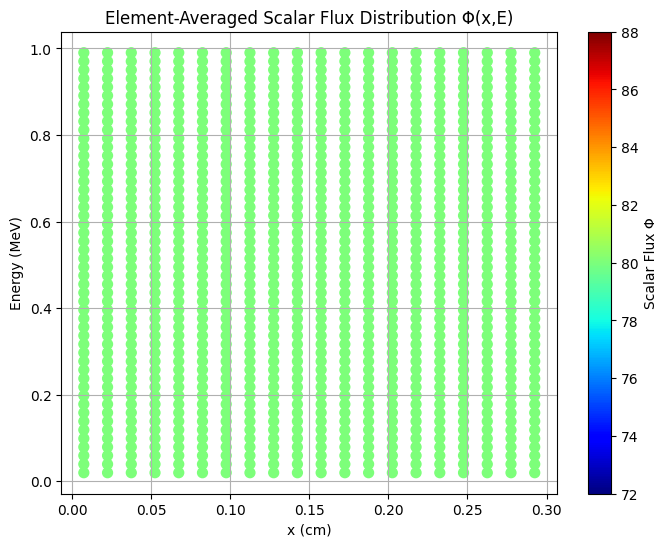

In [19]:
# Set the initial scalar flux
phi = mfem.GridFunction(fes)
phi.Assign(0.0)  # initial guess for scalar flux

# Temporary gridfunction for psi
psi = mfem.GridFunction(fes)

# Loop over angular discretization
for n in range(N_ang):
    mu, w = mu_vals[n], w_vals[n]
    print("Solving for mu =", mu)

    # Create velocity coefficient based on mu and S(E)
    v_coef = VelocityCoefficient(mu, S_coeff)

    # Set up the DG bilinear form A(.,.)
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef, -1.0))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coef, -1.0))
    a.AddBdrFaceIntegrator(mfem.DGTraceIntegrator(inflow_val, v_coef, -1.0, -0.5))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    # Set up linear form b(.)
    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    #b.AddDomainIntegrator(mfem.DomainLFIntegrator(scattering_source))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0)  # initial guess
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)

    print("    GMRES iterations =", solver.GetNumIterations(), "final norm =", solver.GetFinalNorm())

        # Accumulate weighted flux to phi
    phi_new.Add(w, psi)

phi.Assign(phi_new)

# Compute cell centers and element-wise average flux for plotting
num_cells = mesh.GetNE()
cell_centers = np.zeros((num_cells, 2))
phi_cell_avg = np.zeros(num_cells)
center = mfem.Vector(dim)

for i in range(num_cells):
    mesh.GetElementCenter(i, center)
    cell_centers[i, :] = [center[0], center[1]]
    dof_indices = fes.GetElementDofs(i)
    phi_vals = [phi[dof] for dof in dof_indices]
    phi_cell_avg[i] = np.mean(phi_vals)

# Plot the scalar flux distribution.
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sc = plt.scatter(cell_centers[:, 0], cell_centers[:, 1], c=phi_cell_avg, cmap='jet', s=50)
plt.colorbar(sc, label='Scalar Flux Φ')
plt.xlabel("x (cm)")
plt.ylabel("Energy (MeV)")
plt.title("Element-Averaged Scalar Flux Distribution Φ(x,E)")
plt.grid(True)
plt.show()




